In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)

In [2]:
def write_to_csv(loans):
    num_files = 4
    num_loans = loans.shape[0]
    loans_per_file = num_loans / num_files
    print "%d loans per file" % loans_per_file
    start = 0
    index = 0
    while start < num_loans:
        filename = './data/loans_2012_to_2013_' + str(index) + '.csv'
        loans[start:start+loans_per_file].to_csv(filename, index=False)
        print "%s;%d;%d" % (filename, start, start+loans_per_file)
        start += loans_per_file
        index += 1

## Read in dataset of all loans issued by Lending Club in 2012 and 2013

In [3]:
def read_from_csv():
    dataframes = []
    for i in range(5):
        filename = './data/loans_2012_to_2013_' + str(i) + '.csv'
        df = pd.read_csv(filename, low_memory=False)
        dataframes.append(df)
    loans = pd.concat(dataframes)
    return loans

In [4]:
loans = read_from_csv()

# 154,621 of the 188,181 loans were taken out for credit card debt consolidation. We will only look at those loans for this analysis

In [5]:
loans.shape

(188181, 145)

In [6]:
loans.purpose.value_counts()

debt_consolidation    111451
credit_card            43170
home_improvement       10297
other                   8896
major_purchase          3659
small_business          2745
car                     1951
medical                 1519
wedding                 1331
house                   1093
moving                  1038
vacation                 909
renewable_energy         122
Name: purpose, dtype: int64

In [7]:
consolidation_loans = loans[(loans['purpose'] == 'debt_consolidation') | (loans['purpose'] == 'credit_card')]

In [8]:
consolidation_loans.shape

(154621, 145)

# Some exploratory data analysis

First remove all loans that haven't matured yet.
We want to know
* average interest rate by subgrade
* average other debt. Any correlation to loan amount or grade.
* amortization chart of high vs low interest
* default rate by subgrade
* model of reducing interest rate by x% for good behavior, decrease default by y%. Is return of portfolio greater?

In [9]:
consolidation_loans.loan_status.value_counts()

Fully Paid            123870
Charged Off            23745
Current                 6588
Late (31-120 days)       224
In Grace Period          140
Late (16-30 days)         53
Default                    1
Name: loan_status, dtype: int64

In [10]:
# Remove whitespace from term and loan_status
consolidation_loans.term = consolidation_loans.term.apply(lambda x: x.strip())
consolidation_loans.loan_status = consolidation_loans.loan_status.apply(lambda x: x.strip())
consolidation_loans['defaulted'] = consolidation_loans.loan_status.apply(lambda x: 1 if x == 'Charged Off' else 0)

/Users/anishb/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/anishb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
# Remove loans that are still current
consolidation_loans = consolidation_loans.loc[(consolidation_loans.loan_status == 'Fully Paid')
                                              | (consolidation_loans.loan_status == 'Charged Off'),]

In [12]:
# Convert int_rate to a float
consolidation_loans.int_rate = consolidation_loans.int_rate.apply(lambda x: float(x.strip()[:-1]))

## Following conventions, interest rate is directly proportional to borrower credit risk

In [13]:
# Average interest rate and charge off by subgrade
sub_grades = pd.unique(consolidation_loans.sub_grade)
sub_grades.sort()
mean_int_rates = []
charge_off_percentage = []
for sub_grade in sub_grades:
    mean_int_rates.append(consolidation_loans.loc[consolidation_loans.sub_grade == sub_grade, 'int_rate'].mean())
    num_charge_offs = consolidation_loans.loc[(consolidation_loans.sub_grade == sub_grade)
                                              & (consolidation_loans.loan_status == 'Charged Off')].shape[0]
    num_loans = consolidation_loans.loc[(consolidation_loans.sub_grade == sub_grade)].shape[0]
    charge_off_percentage.append(float(num_charge_offs) / num_loans)

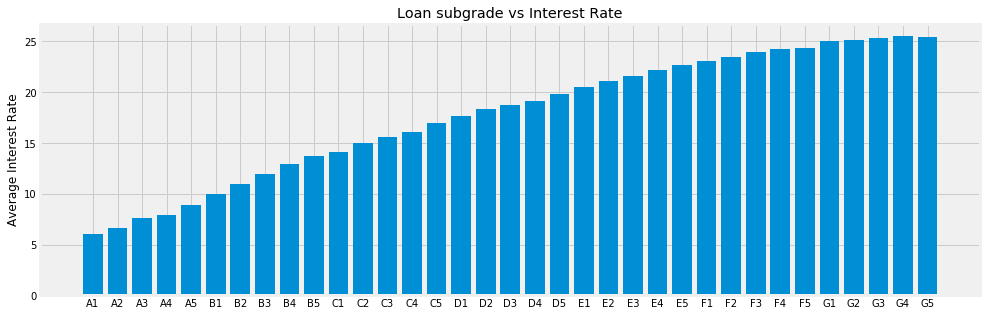

In [14]:
fig = plt.figure(figsize=(15, 5))
bar_locations = np.arange(len(sub_grades))
plt.bar(bar_locations, mean_int_rates);
plt.xticks(bar_locations, sub_grades)
plt.ylabel('Average Interest Rate')
plt.title('Loan subgrade vs Interest Rate')
plt.figure(figsize=(35,5))
plt.show()

## As expected, default rates are higher in the lower grade loans

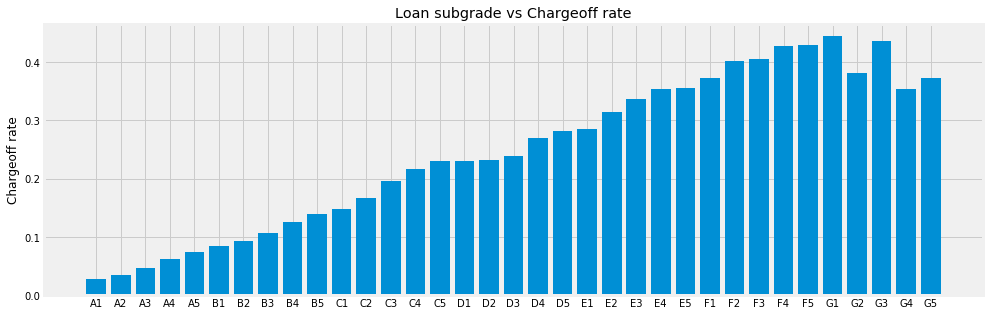

In [15]:
fig = plt.figure(figsize=(15, 5))
bar_locations = np.arange(len(sub_grades))
plt.bar(bar_locations, charge_off_percentage);
plt.xticks(bar_locations, sub_grades)
plt.ylabel('Chargeoff rate')
plt.title('Loan subgrade vs Chargeoff rate')
plt.figure(figsize=(35,5))
plt.show()

## What are indicators of a borrower risk?

In [16]:
loans_risk = consolidation_loans[['defaulted', 'dti', 'delinq_2yrs', 'revol_util', 'inq_last_6mths', 'total_bal_ex_mort', 'mths_since_last_delinq']]
loans_risk = loans_risk[loans_risk.revol_util.notnull()]
loans_risk['revol_util'] = loans_risk.revol_util.apply(lambda x: float(x.strip()[:-1]))

In [17]:
loans_risk.corr()

,defaulted,dti,delinq_2yrs,revol_util,inq_last_6mths,total_bal_ex_mort,mths_since_last_delinq
defaulted,1.000000,0.088044,0.004091,0.066546,0.059740,-0.010195,0.000028
dti,0.088044,1.000000,-0.013931,0.155837,0.026787,0.308753,0.020216
delinq_2yrs,0.004091,-0.013931,1.000000,-0.019880,0.025075,0.032252,-0.588938
revol_util,0.066546,0.155837,-0.019880,1.000000,-0.081729,0.100757,0.037840
inq_last_6mths,0.059740,0.026787,0.025075,-0.081729,1.000000,0.087402,-0.003432
total_bal_ex_mort,-0.010195,0.308753,0.032252,0.100757,0.087402,1.000000,-0.027853
mths_since_last_delinq,0.000028,0.020216,-0.588938,0.037840,-0.003432,-0.027853,1.000000


As expected, dti (debt to income ratio), number of credit inquiries in the past 6 months, and revolving credit utilization have a strong correlation to borrower default.

## Let's take a look at 3 year loans

In [18]:
a_avg_int_rate = consolidation_loans.loc[((consolidation_loans.grade == 'A') &
                                          (consolidation_loans.term == '36 months')),].int_rate.mean()
g_avg_int_rate = consolidation_loans.loc[((consolidation_loans.grade == 'G') &
                                         (consolidation_loans.term == '36 months')),].int_rate.mean()
average_loan_amount = consolidation_loans.loc[consolidation_loans.term == '36 months'].loan_amnt.mean()
print 'Average Grade A Interest Rate = %f' % a_avg_int_rate
print 'Average Grade G Interest Rate = %f' % g_avg_int_rate
print 'Average loan amount = $%d' % int(average_loan_amount)

Average Grade A Interest Rate = 7.722641
Average Grade G Interest Rate = 24.969615
Average loan amount = $12983


In [ ]:
class FixedInterestCalculator(object):
    
    def __init__(self, principal, interest_rate, num_months):
        self.principal = principal
        self.interest_rate = interest_rate
        self.num_months = num_months
        self._rate_per_month = interest_rate / 12.0
        self._monthly_payment = self.monthly_payment()
        self._balance = {}
        self._interest_payment = {}
        self._principal_payment = {}
        
    def monthly_payment(self):
        r = self.interest_rate / 12.0
        payment = (r * self.principal) / (1 - (1 + r)**(-self.num_months))
        return payment
    
    def balance(self, month):
        if month == 0:
            return self.principal
        if month in self._balance:
            return self._balance[month]
        self._balance[month] = self.balance(month - 1) - self.principal_payment(month)
        return self._balance[month]
    
    def interest_payment(self, month):
        if month == 0:
            return 0.0
        if month in self._interest_payment:
            return self._interest_payment[month]
        self._interest_payment[month] = self._rate_per_month * self.balance(month - 1)
        return self._interest_payment[month]
    
    def principal_payment(self, month):
        if month == 0:
            return 0.0
        if month in self._principal_payment:
            return self._principal_payment[month]
        self._principal_payment[month] = self._monthly_payment - self.interest_payment(month)
        return self._principal_payment[month]

### What does the amortization look like for the average grade A, 3 year loan ($12983 at 7.72% interest)?

In [ ]:
calculator = FixedInterestCalculator(12983.00, 0.0772, 36)
months = np.arange(1, 37)
interest, principal = [], []
for month in months:
    interest.append(calculator.interest_payment(month))
    principal.append(calculator.principal_payment(month))

In [ ]:
width = 0.75
fig = plt.figure(figsize=(15, 5))
p1 = plt.bar(months, principal, width)
p2 = plt.bar(months, interest, width, bottom=principal)
plt.ylabel('Monthly Payment')
plt.title('Principal and interest payments')
plt.xticks(months)
plt.legend((p1[0], p2[0]), ('Principal', 'Interest'))
plt.figure(figsize=(60,5))
plt.show();

In [ ]:
print "Monthly payments = $%.2f" % calculator.monthly_payment()
print "Total interest paid = $%.2f" % sum(interest)

### What does the respective amortization look like for the average grade G, 3 year loan ($12983 at 24.97% interest)

In [ ]:
calculator = FixedInterestCalculator(12983.00, 0.2497, 36)
months = np.arange(1, 37)
interest, principal = [], []
for month in months:
    interest.append(calculator.interest_payment(month))
    principal.append(calculator.principal_payment(month))

In [ ]:
width = 0.75
fig = plt.figure(figsize=(15, 5))
p1 = plt.bar(months, principal, width)
p2 = plt.bar(months, interest, width, bottom=principal)
plt.ylabel('Monthly Payment')
plt.title('Principal and interest payments')
plt.xticks(months)
plt.legend((p1[0], p2[0]), ('Principal', 'Interest'))
plt.figure(figsize=(60,5))
plt.show();

In [ ]:
print "Monthly payments = $%.2f" % calculator.monthly_payment()
print "Total interest paid = $%.2f" % sum(interest)